In [57]:
%%capture
!python -m spacy download en_core_web_sm
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\egha355\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [60]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import json

import pandas as pd
import numpy as np 
import re

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
sns.set()

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\egha355\AppData\Roaming\nltk_data...


True

<ol>
    <li>Clean text
        <ul>
            <li> Parse words
            <li> Remove all special characters
            <li> Cleaned formatting
        </ul>
    <li> Tokenize
         <ul>
             <li> Words
        </ul>
    <li> Counts
         <ul>
             <li> Word Count w/ visualization
        </ul>
    <li> Stop Word Removal 
    <li> Lemmatization
</ol>

# Loading data and EDA

To ensure the model's ability to generalize well, it is recommended to have a substantial amount of data, ideally several thousands, from both job descriptions and resumes. Having a diverse and representative dataset allows the model to learn patterns and relationships across various job domains and applicant profiles. This larger dataset helps reduce the risk of overfitting and improves the model's ability to make accurate predictions on unseen data. Additionally, a sufficient amount of data enables the model to capture the nuances and variations present in real-world scenarios, leading to more reliable and robust results. However for the proof of concept we consider a small subset of data, that can be used for skill extraction quickly.

In [4]:
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# read data from csv file. data was downloaded from Kaggle, scraped from indeed.com
df = pd.read_csv(r'data/indeed_job_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        5715 non-null   int64  
 1   Job_Title                         5715 non-null   object 
 2   Link                              5715 non-null   object 
 3   Queried_Salary                    5715 non-null   object 
 4   Job_Type                          5715 non-null   object 
 5   Skill                             5483 non-null   object 
 6   No_of_Skills                      5715 non-null   int64  
 7   Company                           5611 non-null   object 
 8   No_of_Reviews                     4753 non-null   float64
 9   No_of_Stars                       4753 non-null   float64
 10  Date_Since_Posted                 5611 non-null   float64
 11  Description                       5413 non-null   object 
 12  Locati

In [5]:
# more that 5000 data. More clean data would affect the model performance positively.
df.shape

(5715, 43)

In [6]:
# check the columns
df.columns

Index(['Unnamed: 0', 'Job_Title', 'Link', 'Queried_Salary', 'Job_Type',
       'Skill', 'No_of_Skills', 'Company', 'No_of_Reviews', 'No_of_Stars',
       'Date_Since_Posted', 'Description', 'Location', 'Company_Revenue',
       'Company_Employees', 'Company_Industry', 'python', 'sql',
       'machine learning', 'r', 'hadoop', 'tableau', 'sas', 'spark', 'java',
       'Others', 'CA', 'NY', 'VA', 'TX', 'MA', 'IL', 'WA', 'MD', 'DC', 'NC',
       'Other_states', 'Consulting and Business Services',
       'Internet and Software', 'Banks and Financial Services', 'Health Care',
       'Insurance', 'Other_industries'],
      dtype='object')

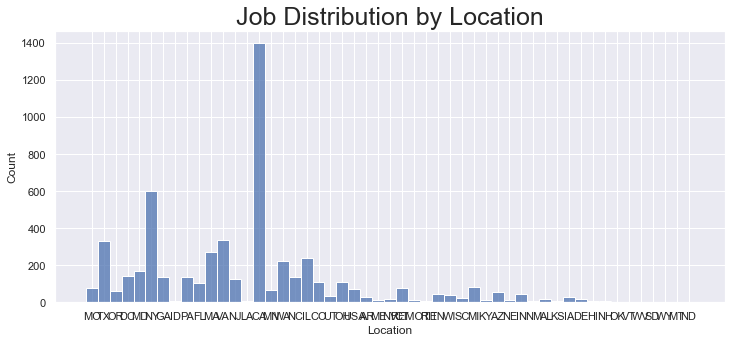

In [14]:
# The jobs are from different locations and not distributed evenly.
plt.figure(figsize = (12,5))
sns.histplot (df['Location'])
plt.title('Job Distribution by Location', size = 25);

In [15]:
# The jobs are for different roles but mostly in the tech industry.
df['Job_Title'].value_counts().head(10)

Data Scientist              715
Data Analyst                405
Data Engineer               391
Senior Data Scientist       205
Senior Data Engineer        136
Senior Data Analyst          86
Big Data Engineer            80
Principal Data Scientist     62
Lead Data Scientist          49
Sr. Data Scientist           45
Name: Job_Title, dtype: int64

Because the jobs are not distributed evenly in the dataset, it might not generalize well for the jobs that we have less data.

# Preprocessing

Let's see a job description to get a sense of the data.

In [8]:
df['Description'].iloc[0]

'[<p><b>POSITION SUMMARY</b></p>, <p>\r\r\nThe Business Analyst role is the primary architect of reporting and dashboard solutions for internal and external clients. Utilizing ESI corporate standard development tools this position is responsible for the design, development, implementation, analysis, interpretation and communication of business information based on the needs of individual clients. The ability to balance overall aesthetics with robust and intuitive functionality is a critical requirement for success in this position.</p>, <p><b>\r\r\nESSENTIAL FUNCTIONS</b></p>, <ul><li>\r\r\nSuccessfully design and implement external client data reporting and dashboard solutions with a strong focus on product aesthetics and functionality.</li><li>\r\r\nAid in the design, development, and implementation of new product ideas for external and internal clients.</li><li>\r\r\nMaintain Live and Data Warehouse Business Objects Universes; add new fields, modify table joins, implement data struc

We need to clean the data by removing irrelevant information.  

In [17]:
def clean_text(raw):
    '''Clean text from html tags, brackets, new lines, and duplicate whitespace.'''
    try:
        # remove new lines
        raw = raw.replace('\r', '')
        raw = raw.replace('\n', '')
        
        # brackets appear in all instances
        raw = raw.replace('[', '')
        raw = raw.replace(']', '')
        raw = raw.replace(')', '')
        raw = raw.replace('(', '')
        
        # removing html tags
        clean_html = re.compile('<.*?>')
        clean_text = re.sub(clean_html, ' ', raw)
        
        # removing duplicate whitespace in between words
        clean_text = re.sub(" +", " ", clean_text) 
        
        # stripping first and last white space 
        clean_text = clean_text.strip()
        
        # commas had multiple spaces before and after in each instance
        clean_text = re.sub(" , ", ", ", clean_text) 
        
        # eliminating the extra comma after a period
        clean_text = clean_text.replace('.,', '.')
        
        # using try and except due to Nan in the column
    except:
        clean_text = np.nan
        
    return clean_text

In [29]:
df_desc = df.Description.apply(clean_text)
df_desc.iloc[0]

'POSITION SUMMARY, The Business Analyst role is the primary architect of reporting and dashboard solutions for internal and external clients. Utilizing ESI corporate standard development tools this position is responsible for the design, development, implementation, analysis, interpretation and communication of business information based on the needs of individual clients. The ability to balance overall aesthetics with robust and intuitive functionality is a critical requirement for success in this position. ESSENTIAL FUNCTIONS, Successfully design and implement external client data reporting and dashboard solutions with a strong focus on product aesthetics and functionality. Aid in the design, development, and implementation of new product ideas for external and internal clients. Maintain Live and Data Warehouse Business Objects Universes; add new fields, modify table joins, implement data structures that streamline report extraction and data analysis. Develop and document best practi

In [30]:
# change the type from series to df and drop all missing values total: 301 missing descriptions
df_desc = pd.DataFrame(df_desc)
df_desc.dropna(inplace = True)
df_desc.reset_index(inplace = True, drop = True)

## Tokenize text data

In [35]:
# create a temp column for lowercased description
df_desc['lower_description'] = df_desc.Description.str.lower()
# regexp tokenizer eliminates the punctuation for the word count and is faster than word_tokenizer
tokenizer = RegexpTokenizer(r"\w+")
df_desc['word_tokenized'] = df_desc.lower_description.apply(lambda row: tokenizer.tokenize(row))

In [36]:
df_desc.word_tokenized.head()

0    [position, summary, the, business, analyst, ro...
1    [what, do, we, need, you, to, have, an, amazin...
2    [validate, analyze, and, conduct, statistical,...
3    [full, time, washington, dc, metro, area, star...
4    [assist, in, consultations, with, business, pa...
Name: word_tokenized, dtype: object

<Figure size 864x360 with 0 Axes>

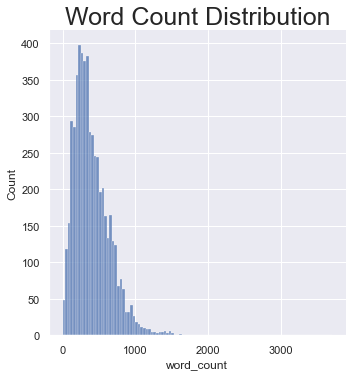

In [38]:
# obtains a word count for each individual job description 
df_desc['word_count'] = df_desc.word_tokenized.str.len()
plt.figure(figsize = (12,5))
sns.displot(df_desc['word_count'])
plt.title('Word Count Distribution', size = 25);

## Remove stop words

In [ ]:
# tokenize the text and remove stop words
def tokenize_text(data):
    nlp = spacy.load('en_core_web_sm')
    data['job_description'] = data['job_description'].apply(lambda x: nlp(x))
    data['job_description'] = data['job_description'].apply(lambda x: [token.lemma_ for token in x if not token.is_stop and not token.is_punct and not token.is_digit and not token.is_space])

    return data

In [40]:
df_desc.head()

,Description,lower_description,word_tokenized,word_count
0,"POSITION SUMMARY, The Business Analyst role is...","position summary, the business analyst role is...","[position, summary, the, business, analyst, ro...",424
1,"What do we need?, You to have an amazing perso...","what do we need?, you to have an amazing perso...","[what, do, we, need, you, to, have, an, amazin...",286
2,"Validate, analyze, and conduct statistical ana...","validate, analyze, and conduct statistical ana...","[validate, analyze, and, conduct, statistical,...",314
3,"Full time, Washington, DC metro area, Starting...","full time, washington, dc metro area, starting...","[full, time, washington, dc, metro, area, star...",297
4,Assist in consultations with business partners...,assist in consultations with business partners...,"[assist, in, consultations, with, business, pa...",316


set

In [58]:
def stopword_removal(text):
    stop_words = set(stopwords.words('english'))
    cleaned = [word for word in text if word not in stop_words]
    return cleaned

df_desc['clean_words'] = df_desc.word_tokenized.apply(stopword_removal)

## Lemmatization

In [61]:
def lemming(text):
    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(word) for word in text]
    return lemmed

df_desc['clean_lemmed'] = df_desc.clean_words.apply(lemming)

In [64]:
df_desc.word_tokenized

0       [position, summary, the, business, analyst, ro...
1       [what, do, we, need, you, to, have, an, amazin...
2       [validate, analyze, and, conduct, statistical,...
3       [full, time, washington, dc, metro, area, star...
4       [assist, in, consultations, with, business, pa...
                              ...                        
5408    [as, a, data, software, engineer, you, will, f...
5409    [want, to, change, the, world, how, about, con...
5410    [identify, and, solve, hybrid, cloud, data, en...
5411    [at, capital, one, we, re, building, a, leadin...
5412    [develops, parallel, data, intensive, systems,...
Name: word_tokenized, Length: 5413, dtype: object

In [69]:
df_desc.head()

,Description,lower_description,word_tokenized,word_count,clean_words,clean_lemmed
0,"POSITION SUMMARY, The Business Analyst role is...","position summary, the business analyst role is...","[position, summary, the, business, analyst, ro...",424,"[position, summary, business, analyst, role, p...","[position, summary, business, analyst, role, p..."
1,"What do we need?, You to have an amazing perso...","what do we need?, you to have an amazing perso...","[what, do, we, need, you, to, have, an, amazin...",286,"[need, amazing, personality, communication, st...","[need, amazing, personality, communication, st..."
2,"Validate, analyze, and conduct statistical ana...","validate, analyze, and conduct statistical ana...","[validate, analyze, and, conduct, statistical,...",314,"[validate, analyze, conduct, statistical, anal...","[validate, analyze, conduct, statistical, anal..."
3,"Full time, Washington, DC metro area, Starting...","full time, washington, dc metro area, starting...","[full, time, washington, dc, metro, area, star...",297,"[full, time, washington, dc, metro, area, star...","[full, time, washington, dc, metro, area, star..."
4,Assist in consultations with business partners...,assist in consultations with business partners...,"[assist, in, consultations, with, business, pa...",316,"[assist, consultations, business, partners, in...","[assist, consultation, business, partner, inte..."


## Training data
Using rule-based skill extraction is very cumbersome and every time a new example is added we might need to update the rules. This is where the machine learning shines. To use machine learning for this problem, first we need to create annotated training data. The best approach is annotating the data manually but here we use spaCy to annotate data. Other option is to use openai gpt3 to annotate the files.
Here is the code that shows how to do it.

```import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")
text = "I use python everyday"
prompt = "Extract skills from {text}"

completion = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    max_tokens=100,
    n=1,
    stop=None,
    temperature=0.7,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
)

print(completion.choices[0].text.strip())```

In [78]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import DocBin, Span
from spacy.language import Language

nlp = spacy.load("en_core_web_sm")
skill_patterns = []

# Read the list of skills from the file
with open('data/LINKEDIN_SKILLS_ORIGINAL.txt', 'r', encoding='utf-8') as f:
    for line in f:
        skill_patterns.append(nlp(line.strip().lower()))

matcher = PhraseMatcher(nlp.vocab)
matcher.add("SKILL", skill_patterns)

# Define the custom component
@Language.component("skill_component")
def skill_component_function(doc):
    matches = matcher(doc)
    matches = sorted(matches, key=lambda match: match[2] - match[1], reverse=True)
    seen_tokens = set()
    spans = []
    for match_id, start, end in matches:
        if any(token.i in seen_tokens for token in doc[start:end]):
            continue
        seen_tokens.update(range(start, end))
        span = Span(doc, start, end, label="SKILL")
        spans.append(span)
    doc.ents = spans
    return doc

In [79]:


# Add the custom component to the pipeline after the "ner" component
nlp.add_pipe("skill_component", after="ner")

# Process the DataFrame column and save the annotations using DocBin
docs = list(nlp.pipe(df_desc['lower_description'].values))
doc_bin = DocBin(docs=docs)
doc_bin.to_disk("annotated_file.spacy")

print("Annotations saved to annotated_file.spacy")
print(nlp.pipe_names)

Annotations saved to annotated_file.spacy
['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'skill_component']


We split the data into training and development sets, with 80% of the data allocated to the training set and the remaining 20% assigned to the development set
which is common practice when we do not have big data.

In [80]:
from sklearn.model_selection import train_test_split

# Load the original DocBin file
doc_bin = DocBin().from_disk("annotated_file.spacy")

# Convert DocBin to list of Doc objects
docs = list(doc_bin.get_docs(nlp.vocab))

# Split the data into train and test sets
train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=42)

# Create DocBins for train and test sets
train_doc_bin = DocBin(docs=train_docs)
test_doc_bin = DocBin(docs=test_docs)

# Save the train and test DocBins
train_doc_bin.to_disk("data/train_data.spacy")
test_doc_bin.to_disk("data/test_data.spacy")

# Machine Learning Model

Rule-based matching for skills is not ideal for generalizing because it relies on predefined patterns and may struggle with unseen data. To achieve better performance and adaptability, machine learning is the preferred approach. In this case, we utilize spaCy, specifically its pipelines for `tok2vec` and `ner`, to train a model capable of predicting and extracting skills.

`tok2vec` is a powerful component in spaCy's pipeline due to its contextual understanding, making it superior in terms of semantic similarity compared to Word2Vec, another popular word embedding method. Moreover, contextual embeddings can be pretrained on domain-specific data, enabling them to capture domain-specific language patterns and enhance performance on specific domains or tasks.

We store the hyperparameters and configurations in the `config.cfg` file. For this model, we have chosen a learning rate of 0.001, Adam optimizer, and a dropout rate of 0.1. However, to further optimize the model's performance, it is crucial to conduct hyperparameter tuning. This involves trying different combinations of hyperparameters and performing grid search to identify the best parameter set that yields optimal results.

To facilitate hyperparameter tuning, we split the data into training, development, and testing sets, allocating 60% for training, 20% for development, and 20% for testing. Through iterative experimentation, we can assess the model's performance with various parameter configurations and select the most effective one.

Given that this is a prototype and proof of concept, our focus will primarily be on developing and evaluating the model.

In [81]:
!python -m spacy init fill-config data/base_config.cfg data/config.cfg

✔ Auto-filled config with all values
✔ Saved config
data\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [83]:
!python -m spacy train data/config.cfg --output ./output --paths.train data/train_data.spacy --paths.dev data/test_data.spacy

ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    111.67    3.35    3.03    3.73    0.03
  0     200        353.99  12909.47   80.87   85.79   76.48    0.81
  0     400        344.26   5441.83   84.44   85.69   83.23    0.84
  0     600        324.30   4464.79   86.28   91.33   81.76    0.86
  0     800        306.16   4126.24   86.59   87.22   85.98    0.87
  0    1000        252.85   3166.26   89.40   91.04   87.82    0.89
  0    1200        284.27   3018.98   90.23   91.81   88.71    0.90
  0    1400        265.48   2787.42   90.45   92.34   88.63    0.90
  0    1600        279.25   289

[2023-05-18 07:24:26,337] [INFO] Set up nlp object from config
[2023-05-18 07:24:26,348] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-05-18 07:24:26,352] [INFO] Created vocabulary
[2023-05-18 07:24:26,352] [INFO] Finished initializing nlp object
[2023-05-18 07:24:49,218] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


The result of skill extraction using spaCy shows an improvement in performance over multiple iterations. The evaluation metrics, such as ENTS_F, ENTS_P, ENTS_R, and SCORE, indicate the accuracy and precision of the extracted skills.

Based on the results, the model achieves an F1 score of around 97% after 5,000 iterations, indicating that it performs well in identifying and extracting skills from the text.

## Evaluate the model

In [ ]:
nlp = spacy.load('output/model-best')
file = open('data/LINKEDIN_SKILLS_ORIGINAL.txt', 'r', encoding='utf-8')
with open('cv_test.csv', 'r', encoding='utf-8') as f:
    text = f.read()
doc = nlp(text)
          
for ent in doc.ents:
    print(ent.text, ent.label_)

Upon obtaining the results, it is essential to analyze the confusion matrix to gain insights into the model's performance. By examining the false positives and false negatives, we can identify areas for improvement. There are several approaches we can explore to enhance the model.

Firstly, we can consider incorporating additional rules into the model to refine its predictions. These rules can help address specific patterns or exceptions that the model may struggle with, leading to improved accuracy.

Secondly, leveraging a high-quality, comprehensive dataset can significantly impact the model's performance. By obtaining a well-curated and diverse dataset, we can provide the model with a more robust and representative sample, leading to better generalization and prediction capabilities.

Additionally, transformer-based models, such as BERT, offer promising avenues for improvement. These models leverage advanced architectures and pre-trained contextual embeddings to capture intricate language patterns and semantic relationships effectively. Incorporating such models into the pipeline can potentially enhance the accuracy and overall performance of the skill extraction system.

In summary, to enhance the model's performance, we can consider integrating additional rules, utilizing high-quality data, and exploring transformer-based models like BERT. By iteratively refining the system and leveraging these approaches, we can achieve better skill extraction results and improve overall accuracy.

## Classifying skills

We label the skills and then encode the labels, use word embedding, and then we use transfer learning with BERT to train a model

In [96]:
# with open('data/hard_skills/LINKEDIN_SKILLS_ORIGINAL.txt', 'r', encoding='utf-8') as f:
#     linkedin_skills = f.read().splitlines()

# with open('data/soft_skills/soft_skills0.txt', 'r', encoding='utf-8') as f:
#     soft_skills = f.read().splitlines()

# technical_skills = [skill for skill in linkedin_skills if skill not in soft_skills]

# with open('technical.txt', 'w', encoding='utf-8') as f:
#     for skill in technical_skills:
#         f.write(skill + '\n')        
    

In [102]:
import pandas as pd
import torch
import transformers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# Load and preprocess the data
with open('data/hard_skills/technical.txt', 'r', encoding='utf-8') as f:
    hard_skills = [line.strip() for line in f.readlines()]

with open('data/soft_skills/soft_skills0.txt', 'r', encoding='utf-8') as f:
    soft_skills = [line.strip() for line in f.readlines()]

hard_skills_df = pd.DataFrame({'skill': hard_skills, 'label': 1})
soft_skills_df = pd.DataFrame({'skill': soft_skills, 'label': 0})

data = pd.concat([hard_skills_df, soft_skills_df], ignore_index=True)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the input data
train_encodings = tokenizer(list(train_data['skill']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_data['skill']), truncation=True, padding=True)

# Convert tokenized inputs to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_data['label'].values))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']),
                                              torch.tensor(test_data['label'].values))

# Define the optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model
model.train()
for epoch in range(3):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)
accuracy = total_correct / total_samples

print(f"Accuracy on test set: {accuracy}")

c:\Users\egha355\Envs\datascience\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\egha355\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Resume dataset

To show a prototype for skill extraction, I just did it on the job postings dataset that showed how it works. We could add resume data to the JPs but we should consider they shouldn't be imbalance otherwise the model learns one of them more than the other. we could do resume separetely as there are some rules to find different segments of the resume and get the relevant phrases. If we want to do it separately we can benefit from the rules below that extracts the skill segment. The code inspired by https://github.com/kbrajwani/resume_parser.git

In [ ]:

from __future__ import division
import nltk

import re
import os
from datetime import date

import nltk
import docx2txt
import pandas as pd
from tika import parser

import logging

import spacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher

import sys
import operator
import string
import nltk

# load pre-trained model
base_path = os.path.dirname(__file__)

nlp = spacy.load('en_core_web_sm')

file = os.path.join(base_path,"LINKEDIN_SKILLS_ORIGINAL.txt")
file = open(file, "r", encoding='utf-8')    
skill = [line.strip().lower() for line in file]
skillsmatcher = PhraseMatcher(nlp.vocab)
patterns = [nlp.make_doc(text) for text in skill if len(nlp.make_doc(text)) < 10]
skillsmatcher.add("Job title", None, *patterns)


class SkillExtractor:
    skills_header = (
        'credentials',
        'areas of experience',
        'areas of expertise',
        'areas of knowledge',
        'skills',
        "other skills",
        "other abilities",
        'career related skills',
        'professional skills',
        'specialized skills',
        'technical skills',
        'computer skills',
        'personal skills',
        'computer knowledge',        
        'technologies',
        'technical experience',
        'proficiencies',
        'languages',
        'language competencies and skills',
        'programming languages',
        'competencies'
    )

           
    def convert_docx_to_txt(docx_file,docx_parser):
        """
            A utility function to convert a Microsoft docx files to raw text.

            This code is largely borrowed from existing solutions, and does not match the style of the rest of this repo.
            :param docx_file: docx file with gets uploaded by the user
            :type docx_file: InMemoryUploadedFile
            :return: The text contents of the docx file
            :rtype: str
        """
        try:
          if docx_parser == "tika":
            text = parser.from_file(docx_file, service='text')['content']
          elif docx_parser == "docx2txt":
            text = docx2txt.process(docx_file)
          else:
            logging.error('Choose docx_parser from tika or docx2txt :: ' + str(e)+' is not supported')
            return [], " "
        except RuntimeError as e:            
            logging.error('Error in tika installation:: ' + str(e))
            logging.error('--------------------------')
            logging.error('Install java for better result ')
            text = docx2txt.process(docx_file)
        except Exception as e:
            logging.error('Error in docx file:: ' + str(e))
            return [], " "
        try:
            clean_text = re.sub(r'\n+', '\n', text)
            clean_text = clean_text.replace("\r", "\n").replace("\t", " ")  # Normalize text blob
            resume_lines = clean_text.splitlines()  # Split text blob into individual lines
            resume_lines = [re.sub('\s+', ' ', line.strip()) for line in resume_lines if
                            line.strip()]  # Remove empty strings and whitespaces
            return resume_lines, text
        except Exception as e:
            logging.error('Error in docx file:: ' + str(e))
            return [], " "

    def convert_pdf_to_txt(pdf_file):
        """
        A utility function to convert a machine-readable PDF to raw text.

        This code is largely borrowed from existing solutions, and does not match the style of the rest of this repo.
        :param input_pdf_path: Path to the .pdf file which should be converted
        :type input_pdf_path: str
        :return: The text contents of the pdf
        :rtype: str
        """
            
        try:
            raw_text = parser.from_file(pdf_file, service='text')['content']
        except RuntimeError as e:            
            logging.error('Error in tika installation:: ' + str(e))
            logging.error('--------------------------')
            logging.error('Install java for better result ')
            pdf = pdfplumber.open(pdf_file)
            raw_text= ""
            for page in pdf.pages:
              raw_text += page.extract_text() + "\n"
            pdf.close()                
        except Exception as e:
            logging.error('Error in docx file:: ' + str(e))
            return [], " "
        try:
            full_string = re.sub(r'\n+', '\n', raw_text)
            full_string = full_string.replace("\r", "\n")
            full_string = full_string.replace("\t", " ")

            # Remove awkward LaTeX bullet characters

            full_string = re.sub(r"\uf0b7", " ", full_string)
            full_string = re.sub(r"\(cid:\d{0,2}\)", " ", full_string)
            full_string = re.sub(r'• ', " ", full_string)

            # Split text blob into individual lines
            resume_lines = full_string.splitlines(True)

            # Remove empty strings and whitespaces
            resume_lines = [re.sub('\s+', ' ', line.strip()) for line in resume_lines if line.strip()]

            return resume_lines, raw_text
        except Exception as e:
            logging.error('Error in docx file:: ' + str(e))
            return [], " "
            
    def find_segment_indices(string_to_search, resume_segments, resume_indices):
        for i, line in enumerate(string_to_search):

            if line[0].islower():
                continue

            header = line.lower()

            if [s for s in SkillExtractor.skills_header if header.startswith(s)]:
                try:
                    resume_segments['skills'][header]
                except:
                    resume_indices.append(i)
                    header = [s for s in SkillExtractor.skills_header if header.startswith(s)][0]
                    resume_segments['skills'][header] = i


    def slice_segments(string_to_search, resume_segments, resume_indices):
        resume_segments['contact_info'] = string_to_search[:resume_indices[0]]

        for section, value in resume_segments.items():
            if section == 'contact_info':
                continue

            for sub_section, start_idx in value.items():
                end_idx = len(string_to_search)
                if (resume_indices.index(start_idx) + 1) != len(resume_indices):
                    end_idx = resume_indices[resume_indices.index(start_idx) + 1]

                resume_segments[section][sub_section] = string_to_search[start_idx:end_idx]

    def segment(string_to_search):
        resume_segments = {
            'objective': {},
            'work_and_employment': {},
            'education_and_training': {},
            'skills': {},
            'accomplishments': {},
            'misc': {}
        }

        resume_indices = []

        SkillExtractor.find_segment_indices(string_to_search, resume_segments, resume_indices)
        if len(resume_indices) != 0:
            SkillExtractor.slice_segments(string_to_search, resume_segments, resume_indices)
        else:
            resume_segments['contact_info'] = []

        return resume_segments
    
    def extract_skills(text):

        skills = []

        __nlp = nlp(text.lower())
        # Only run nlp.make_doc to speed things up

        matches = skillsmatcher(__nlp)
        for match_id, start, end in matches:
            span = __nlp[start:end]
            skills.append(span.text)
        skills = list(set(skills))
        return skills


    def get_skills(file,docx_parser = "tika"):
        """
        file : Give path of resume file
        docx_parser : Enter docx2txt or tika, by default is tika
        """
        # file = "/content/Asst Manager Trust Administration.docx"
        file = os.path.join(file)
        if file.endswith('docx') or file.endswith('doc'):
            if file.endswith('doc') and docx_parser == "docx2txt":
              docx_parser = "tika"
              logging.error("doc format not supported by the docx2txt changing back to tika")
            resume_lines, raw_text = SkillExtractor.convert_docx_to_txt(file,docx_parser)
        elif file.endswith('pdf'):
            resume_lines, raw_text = SkillExtractor.convert_pdf_to_txt(file)
        elif file.endswith('txt'):
            with open(file, 'r', encoding='latin') as f:
                resume_lines = f.readlines()

        else:
            resume_lines = None
        resume_segments = SkillExtractor.segment(resume_lines)
        
        
        full_text = " ".join(resume_lines)

        email = SkillExtractor.extract_email(full_text)
        phone = SkillExtractor.find_phone(full_text)
        name = SkillExtractor.extract_name(" ".join(resume_segments['contact_info']))
        total_exp, text = SkillExtractor.get_experience(resume_segments)
        university = SkillExtractor.extract_university(full_text, os.path.join(base_path,'world-universities.csv'))

        designition = SkillExtractor.job_designition(full_text)
        designition = list(dict.fromkeys(designition).keys())

        degree = SkillExtractor.get_degree(full_text)
        company_working = SkillExtractor.get_company_working(full_text)
        
        skills = ""

        if len(resume_segments['skills'].keys()):
            for key , values in resume_segments['skills'].items():
              skills += re.sub(key, '', ",".join(values), flags=re.IGNORECASE)            
            skills = skills.strip().strip(",").split(",")
        
        if len(skills) == 0:
            skills = SkillExtractor.extract_skills(full_text)
        skills = list(dict.fromkeys(skills).keys())
        
        return {
            "email": email,
            "phone": phone,
            "name": name,
            "total_exp": total_exp,
            "university": university,
            "designition": designition,
            "degree": degree,
            "skills": skills,
            "Companies worked at": company_working
        }